In [13]:
from openclean.data.load import dataset
from openclean.pipeline import stream
import pandas as pd

pd.set_option('display.max_rows', None)

data_dir = './project_data/'

data_list = [
   '311_Service_Requests_for_2006.csv',
   '311_Service_Requests_for_2007.csv',
   '311_Service_Requests_for_2009.csv',
   '2021_Open_Data_Plan__Future_Releases.csv',
   'Local_Law_8_of_2020___Complaints_of_Illegal_Parking_of_Vehicles_Operated_on_Behalf_of_the_City.csv',
   'SCOUT_CORE.csv'
]

data_column = [
    'Agency Name', 
    'Agency Name', 
    'Agency Name', 
    'Agency Name', 
    'Agency Name',
    'Agency Name'
]



In [14]:

from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan

from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update


def calc_effectiveness(problem_rows, cleaned_rows):
    precision = intersected_num / cleaned_rows * 1.0 if cleaned_rows != 0 else 0.0
    recall = intersected_num / problem_rows * 1.0 if problem_rows != 0 else 0.0
    print(f"Data cleaned with precision {precision} and recall {recall} in {intersected_num} cleaning rows")
    return precision, recall

def print_cluster(cnumber, cluster):
    print('Cluster {} (of size {})\n'.format(cnumber, len(cluster)))
    for val, count in cluster.items():
        print('{} ({})'.format(val, count))
    print('\nSuggested value: {}\n\n'.format(cluster.suggestion()))

def perform_knn_cluster(ds_full, column, using_collision=True, minsize=2, t=0.6):
    values = ds_full.select(column).distinct()
    clusters = knn_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize) \
        if using_collision else knn_collision_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize)
    print('{} clusters of size {} or greater'.format(len(clusters), minsize))
    clusters.sort(key=lambda c: len(c), reverse=True)
    for i, cluster in enumerate(clusters):
        print_cluster(i + 1, cluster)

def profiling_data(datafile, column):
    ds_full = stream(datafile, encoding='utf-8')
    df = ds_full.to_df()
    Agency = df[column].value_counts()
    print(Agency)
    print("Total locations: ", len(Agency))
    return df
    
def cleaning_data_original(df, column):
    rows_affected_upper = df[df[column] != df[column].str.upper()].index
    df = update(df, columns=column, func=str.upper)
    rows_affected_empty = df.isnull().index
    df = update(df, columns=column, func=lambda x: 'OTHER' if is_empty(x) else x)
    cleaned_rows = rows_affected_upper.union(rows_affected_empty)
    return df, cleaned_rows
    
def save_cleaned_data(df, output='result.csv'):
    df.to_csv('output')

In [15]:
#load all the dataset at once then performing data cleaning to create reference data

Agency_df = pd.DataFrame(columns=['Agency Name'])

for i in range(len(data_list)):
    datafile = data_dir + data_list[i]
    print("Load data: ", datafile)
    ds = dataset(datafile, encoding='utf-8')
   
    Agency = ds[['Agency Name']]
    Agency_df = Agency_df.append(Agency)
    
print(Agency_df.value_counts())

Load data:  ./project_data/311_Service_Requests_for_2006.csv
Load data:  ./project_data/311_Service_Requests_for_2007.csv
Load data:  ./project_data/311_Service_Requests_for_2009.csv
Load data:  ./project_data/2021_Open_Data_Plan__Future_Releases.csv
Load data:  ./project_data/Local_Law_8_of_2020___Complaints_of_Illegal_Parking_of_Vehicles_Operated_on_Behalf_of_the_City.csv
Load data:  ./project_data/SCOUT_CORE.csv
Agency Name                                                                                
Department of Housing Preservation and Development                                             2015506
Department of Transportation                                                                    965161
Department of Environmental Protection                                                          642485
New York City Police Department                                                                 549075
Department of Buildings                                                      

In [16]:
# Generate our reference data
Agency_df.to_csv('../reference_data/Agency_rows_all.csv', index=None)

In [17]:
# Load the intermediate dataset as stream format
ds_full = stream('../reference_data/Agency_rows_all.csv', encoding='utf-8')

In [18]:
# Knn cluster
perform_knn_cluster(ds_full, 'Agency Name')

761 clusters of size 2 or greater
Cluster 1 (of size 77)

School - PS 150 Queens (14)
School - PS 307 Eames Place (2)
School - PS 30 Queens (3)
School - PS 156 Laurelton (3)
School - PS 20 Anna Silver (3)
School - PS 100 Isaac Clason (3)
School - PS 138 Brooklyn (5)
School - PS 173 (2)
School - PS 130 (2)
School - PS 89 Bronx (8)
School - PS 97 Bronx (3)
School - PS 128 Audubon (9)
School - PS 198 (3)
School - PS 149 Danny Kaye (1)
School - PS 1 The Bergen (3)
School - PS 133 (3)
School - PS 245 (1)
School - PS 189 (2)
School - PS 163 Bath Beach (1)
School - PS 164 Queens Valley (2)
School - PS 16 Wakefield (1)
School - PS 73 Bronx (2)
School - PS 176 (3)
School - PS 29 Bardwell (2)
School - PS 123 (10)
School - PS 174 Dumont (1)
School - PS 70 Queens (6)
School - PS 42 Eltingville (6)
School - PS 306 Ethan Allen (8)
School - PS 138 (1)
School - PS 147 Isaac Remsen (1)
School - PS 102 Bayview (3)
School - PS 340 (1)
School - PS 186 Castlewood (1)
School - PS 120 Carlos Tapia (10)
Schoo

In [19]:
df_overall = ds_full.to_df()

In [20]:
df_clean = update(df_overall, columns='Agency Name', func=str.upper)
df_clean = update(df_clean, columns='Agency Name', func=lambda x: 'UNSPECIFIED' if is_empty(x) else x)
Agency = df_clean['Agency Name'].value_counts()
print(Agency)

DEPARTMENT OF HOUSING PRESERVATION AND DEVELOPMENT                                             2015506
DEPARTMENT OF TRANSPORTATION                                                                    965161
DEPARTMENT OF ENVIRONMENTAL PROTECTION                                                          642485
NEW YORK CITY POLICE DEPARTMENT                                                                 549075
DEPARTMENT OF BUILDINGS                                                                         381210
DEPARTMENT OF PARKS AND RECREATION                                                              165511
DEPARTMENT OF HEALTH AND MENTAL HYGIENE                                                         134952
DEPARTMENT OF CONSUMER AFFAIRS                                                                   85726
TAXI AND LIMOUSINE COMMISSION                                                                    68364
BCC - BROOKLYN SOUTH                                                     

In [31]:
abb_map = {'DOT': ' DEPARTMENT OF TRANSPORTATION', 
           'NYPD': 'NEW YORK CITY POLICE DEPARTMENT', 
           'POLICE DEPARTMENT (NYPD)': 'NEW YORK CITY POLICE DEPARTMENT',
           'DOHMH': 'DEPARTMENT OF HEALTH AND MENTAL HYGIENE',
           'DCA': 'DEPARTMENT OF CONSUMER AFFAIRS', 
           'DEPARTMENT OF BUILDINGS (DOB)': 'DEPARTMENT OF BUILDINGS',
           'TAXI AND LIMOUSINE COMMISSION (TLC)': 'TAXI AND LIMOUSINE COMMISSION',
           'TLC': 'TAXI AND LIMOUSINE COMMISSION',
           'DEPARTMENT OF TRANSPORTATION (DOT)': 'DEPARTMENT OF TRANSPORTATION', 
           'DEPARTMENT OF CITY PLANNING (DCP)': 'DEPARTMENT OF CITY PLANNING', 
           'DEPARTMENT OF FINANCE (DOF)': 'DEPARTMENT OF FINANCE',
           'DEPARTMENT OF EDUCATION (DOE)': 'DEPARTMENT OF EDUCATION',
           'CIVILIAN COMPLAINT REVIEW BOARD (CCRB)': 'CIVILIAN COMPLAINT REVIEW BOARD',
           'DEPARTMENT OF PARKS AND RECREATION (DPR)': 'DEPARTMENT OF PARKS AND RECREATION'}

df_clean = update(df_clean, columns='Agency Name', func=lambda x: abb_map[str(x)] if str(x) in abb_map else x)
print(df_clean.value_counts())

Agency Name                                                                                
DEPARTMENT OF HOUSING PRESERVATION AND DEVELOPMENT                                             2015506
DEPARTMENT OF TRANSPORTATION                                                                    965172
DEPARTMENT OF ENVIRONMENTAL PROTECTION                                                          642485
NEW YORK CITY POLICE DEPARTMENT                                                                 549081
DEPARTMENT OF BUILDINGS                                                                         381220
DEPARTMENT OF PARKS AND RECREATION                                                              165519
DEPARTMENT OF HEALTH AND MENTAL HYGIENE                                                         134957
DEPARTMENT OF CONSUMER AFFAIRS                                                                   85896
TAXI AND LIMOUSINE COMMISSION                                                       

In [32]:
from openclean.function.eval.base import Col

def improved_clean_Agency_name(ds_full, column):
    
    ds_full = update(ds_full, columns=column, func=str.upper)
    ds_full = update(ds_full, columns=column, func=lambda x: 'UNSPECIFIED' if is_empty(x) else x)
    ds_full = update(ds_full, columns=column, func=lambda x: str(x).split(';')[0])
    ds_full = update(ds_full, columns=column, func=lambda x: abb_map[str(x)] if str(x) in abb_map else x)
    return ds_full

In [33]:
# Agency types way too many, We tried to visualize the data but the result is not ideal.
import matplotlib.pyplot as plt
import math

plt.rc('font', size=20)
    
def draw_hist(numbers, groups, datapath = ''):
    plt.barh(range(numbers.count()), [math.log(x) for x in numbers], height=97.7, color='steelblue', alpha=0.1)
    plt.xlabel('counts (log)')
    plt.ylabel('Agency Name')
    plt.yticks(range(groups.count()), groups)
    if datapath != '':
        datapath += '/Agency Name_box.jpg'
        plt.savefig(datapath)
    plt.show()

In [34]:
res = df_clean.value_counts().reset_index()
res.columns = ['Agency Name', 'count']
print(res)

                                           Agency Name    count
0    DEPARTMENT OF HOUSING PRESERVATION AND DEVELOP...  2015506
1                         DEPARTMENT OF TRANSPORTATION   965172
2               DEPARTMENT OF ENVIRONMENTAL PROTECTION   642485
3                      NEW YORK CITY POLICE DEPARTMENT   549081
4                              DEPARTMENT OF BUILDINGS   381220
5                   DEPARTMENT OF PARKS AND RECREATION   165519
6              DEPARTMENT OF HEALTH AND MENTAL HYGIENE   134957
7                       DEPARTMENT OF CONSUMER AFFAIRS    85896
8                        TAXI AND LIMOUSINE COMMISSION    68376
9                                 BCC - BROOKLYN SOUTH    50959
10                                BCC - BROOKLYN NORTH    41187
11                                   BCC - QUEENS EAST    32383
12                                 BCC - STATEN ISLAND    29714
13                                        A - BROOKLYN    29276
14                                     B

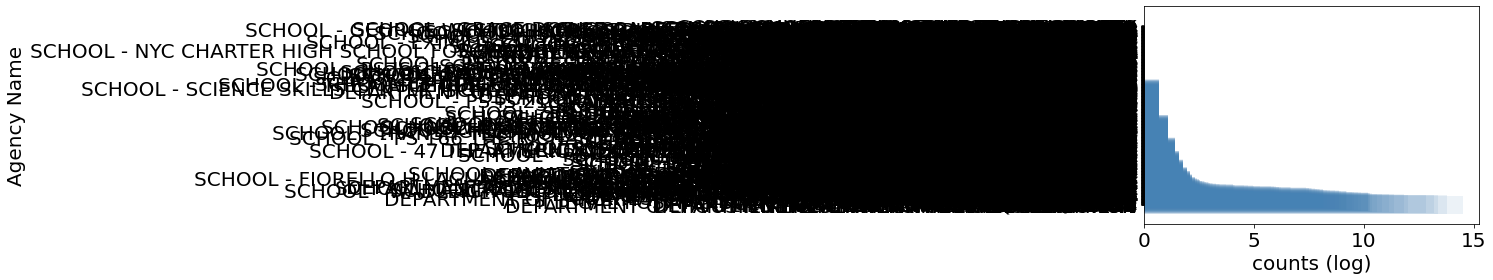

In [35]:
draw_hist(res['count'], res['Agency Name'])